# CT5133 - Deep Learning Assignment: 2


#### Group Member 1: Seshadri Sundarrajan (19230107)        
#### Group Member 2: Manish Agarwal	 (19230064)



Data Source : https://ai.stanford.edu/~amaas/data/sentiment/

### Work Split up
 
#### Seshadri Sundarrajan:

•	Pre-processing: Naïve Bayes

•	Model construction & Evaluation: LSTM


####  Manish Agarwal

•	Pre-processing: LSTM

•	Model construction & Evaluation: Naïve Bayes


Note: Coding part is done as per the above-mentioned split up.


In [107]:
import os

# Get current working directory
pwd = os.getcwd()

# Links to positive and negative train data
pos_train_data_dir = pwd + '\\aclImdb\\train\\pos'
neg_train_data_dir = pwd + '\\aclImdb\\train\\neg'
pos_test_data_dir = pwd + '\\aclImdb\\test\\pos'
neg_test_data_dir = pwd + '\\aclImdb\\test\\neg'

#### Data pre-processing helper functions

In [108]:
import string
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from gensim.parsing.preprocessing import remove_stopwords

# Stemmer object
p_stem = PorterStemmer() 


def get_review_lst(path):
    'Function to read all reviews from the folder and return a list'
    reviews_op = []
    for review in os.listdir(path):
        with open(path+'\\'+review,encoding="utf8") as review: # convert the reviews to utf -8 encoding  format
            reviews_op.append(review.read())
    return reviews_op

def text_cleaning(ip_review_lst):
    'Function to clean the text by removing special characters / escape sequence / punctuation and converts to lower'
    op_review_lst = []
    for review in ip_review_lst:
        review = review.replace('<br />','').replace(',',' ').replace('-',' ') # Reviews have new line as <br /> 
        review = review.translate(str.maketrans(' ', ' ', string.punctuation)).lower() # remove punctuations & make lowercase
        op_review_lst.append(review)
    return op_review_lst

def get_stem(reviews_lst):
    'Function to stem the reviews and remove the stop word'
    reviews_lst_op = []
    for review in reviews_lst:
        stemmed_review = ''
        words = word_tokenize(remove_stopwords(review)) # remove stopwards
        for token in words: 
            stemmed_review += ' ' + p_stem.stem(token) # stem the word
        reviews_lst_op.append(stemmed_review)
    return reviews_lst_op  

# Putting all together
def text_preprocess(path,stem=True):
    '''Function that performs all the neccesary pre processing my calling the above define functions,
    stem parameter is used becaused for lstm we dont stem'''
    reviews = get_review_lst(path)
    reviews = text_cleaning(reviews)
    if stem :
        reviews = get_stem(reviews)
    return reviews


Training data gathering 

In [112]:
# Train labels generation - 0 & 1 for polarities
train_labels = ('1 '*25000).split()
train_labels.extend(('0 '*25000).split())
train_labels = [int(label) for label in train_labels]


In [110]:
positive_reviews = text_preprocess(pos_train_data_dir,stem=True) # Positive reviews
positive_reviews.extend(text_preprocess(pos_test_data_dir,stem=True))
negative_reviews = text_preprocess(neg_train_data_dir,stem=True) # Negative reviews
negative_reviews.extend(text_preprocess(neg_test_data_dir,stem=True))

# Combining both positive and negative reviews
train_reviews= positive_reviews.copy()
train_reviews.extend(negative_reviews)

### Bag of words

In [121]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Count vectorizer with max of 5000 words
vectorizer = CountVectorizer(max_features=7500).fit(train_reviews)

# Bag of words representation
bag_of_words = vectorizer.transform(train_reviews)

# x & y data for sentiment analysis
x = bag_of_words.todense()
y = np.array(train_labels)

### Naive Bayes - Multinomial

In [122]:
from sklearn.model_selection import train_test_split

# Test train split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 0)

In [123]:
from sklearn.naive_bayes import MultinomialNB

classifier_nb = MultinomialNB()
classifier_nb.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

##### Cross validation

In [116]:
from sklearn.model_selection import cross_val_score,cross_val_predict
accuracies_xg = cross_val_score(estimator = classifier_nb, X = x_train, y = y_train, cv = 10)
print('Mean Accuracy for k(10)- fold cross validation = {}%'.format(round(accuracies_xg.mean()*100,3)))

Mean Accuracy for k(10)- fold cross validation = 84.149%


#### Model Evaluation

In [124]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

y_pred_nb = classifier_nb.predict(x_test)
cm_nb = confusion_matrix(y_test,y_pred_nb)
print('Test Accuracy = {}%'.format(float(metrics.accuracy_score(y_test, y_pred_nb))*100))

Test Accuracy = 83.94%


Confusion Matrix

Text(0.5, 1, 'Confusion Matrix of Multinomial Naive Bayes Classifier')

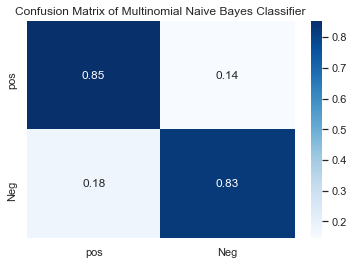

In [125]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set()

sns.heatmap(pd.DataFrame(cm_nb / cm_nb.sum(axis=1),index = ['pos','Neg'], columns = ['pos','Neg']),cmap = 'Blues',annot=True)
plt.title('Confusion Matrix of Multinomial Naive Bayes Classifier')

Classification Report

In [126]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_nb, target_names=['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.83      0.85      0.84      7442
    negative       0.85      0.83      0.84      7558

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



### Neural Network - Approach

In [131]:
from keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
import numpy as np
import tensorflow.compat.v1 as tf_v1

Data Gathering

In [149]:
# Reading the data and just cleaning it ** not doing stemming and stopwords removal **

positive_reviews_rnn = text_preprocess(pos_train_data_dir,stem=False) # Positive reviews
positive_reviews_rnn.extend(text_preprocess(pos_test_data_dir,stem=False))
negative_reviews_rnn = text_preprocess(neg_train_data_dir,stem=False) # Negative reviews
negative_reviews_rnn.extend(text_preprocess(neg_test_data_dir,stem=False))

# Combining both positive and negative reviews
train_reviews= positive_reviews_rnn.copy()
train_reviews.extend(negative_reviews_rnn)

Sequence Tokenizer and Test / Train split

In [150]:
# Keras tokenizer to get the top 5000 words

tokenizer = Tokenizer(num_words = 7500, split=' ')
tokenizer.fit_on_texts(train_reviews)

# Convert the tokenizer as per the sequencial norms

X = tokenizer.texts_to_sequences(train_reviews)
X = pad_sequences(X)

Y = train_labels

# Test train split
x_train, x_test, y_train, y_test = train_test_split(X,np.array(Y), test_size = 0.30, random_state = 0)

Sequence Padding - constant input length

In [151]:
from keras.preprocessing import sequence

# Adjustig review lengths to 500  - Truncating / padding accordingly
x_train = sequence.pad_sequences(x_train, maxlen=500)
x_test = sequence.pad_sequences(x_test, maxlen=500)

X.shape

(50000, 2054)

### LSTM model

In [152]:
# LSTM model

# Setting random seed --> need to use tensor flow seed as its the backend not numpy
tf_v1.set_random_seed(100)



' Input --> Word embedding --> LSTM --> sigmoid'

seq_model = Sequential()
seq_model.add(Embedding(input_dim = 7500, output_dim =25 ,input_length = 500))
seq_model.add(Dropout(0.3)) # Dropout layer to overcome overfitting
seq_model.add(LSTM(units = 50))
seq_model.add(Dropout(0.3))
seq_model.add(Dense(units  = 1,activation='sigmoid')) # output layer

seq_model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

# Model fit
seq_model.fit(x_train, y_train, epochs=10, batch_size=1000,verbose=1)

# Model Accuracy
acc = seq_model.evaluate(x_test, y_test, verbose=0)[1]
print('Accuracy of the model = {}%'.format(round(acc*100,2)))

Train on 35000 samples
Epoch 1/10
35000/35000 [==============================] - 6s 177us/sample - loss: 0.6730 - accuracy: 0.6160
Epoch 2/10
35000/35000 [==============================] - 4s 107us/sample - loss: 0.5497 - accuracy: 0.7805
Epoch 3/10
35000/35000 [==============================] - 4s 106us/sample - loss: 0.4399 - accuracy: 0.8299
Epoch 4/10
35000/35000 [==============================] - 4s 107us/sample - loss: 0.3214 - accuracy: 0.8727
Epoch 5/10
35000/35000 [==============================] - 4s 108us/sample - loss: 0.2501 - accuracy: 0.9029
Epoch 6/10
35000/35000 [==============================] - 4s 106us/sample - loss: 0.2155 - accuracy: 0.9207
Epoch 7/10
35000/35000 [==============================] - 4s 106us/sample - loss: 0.1940 - accuracy: 0.9296
Epoch 8/10
35000/35000 [==============================] - 4s 106us/sample - loss: 0.1812 - accuracy: 0.9351
Epoch 9/10
35000/35000 [==============================] - 4s 106us/sample - loss: 0.1744 - accuracy: 0.9383
Epoch

In [154]:
seq_model.summary()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 500, 25)           187500    
_________________________________________________________________
dropout_30 (Dropout)         (None, 500, 25)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                15200     
_________________________________________________________________
dropout_31 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 202,751
Trainable params: 202,751
Non-trainable params: 0
_________________________________________________________________


Model evaluation

In [155]:
y_prob = seq_model.predict(x_test) 
y_pred_lstm = (y_prob > 0.5).astype(int).transpose().tolist()[0]

from sklearn.metrics import confusion_matrix
from sklearn import metrics


cm_lstm = confusion_matrix(y_test,y_pred_lstm)

Confusion Matrix

Text(0.5, 1, 'Confusion Matrix of LSTM')

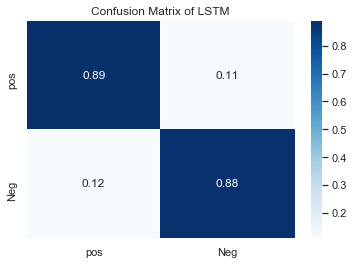

In [156]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set()

sns.heatmap(pd.DataFrame(cm_lstm / cm_lstm.sum(axis=1),index = ['pos','Neg'], columns = ['pos','Neg']),cmap = 'Blues',annot=True)
plt.title('Confusion Matrix of LSTM')

Classification Report

In [157]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lstm, target_names=['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.88      0.89      0.89      7442
    negative       0.89      0.88      0.89      7558

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



### Model Evaluation based on unseen events

In [173]:
# LSTM

rev = ['A movie of a cynicism so vast and pervasive as to render the viewing experience even emptier than its slapdash aesthetic does.']

test_rev = text_cleaning(rev)

test_rev = tokenizer.texts_to_sequences(test_rev)
test_rev = pad_sequences(test_rev)
test_rev = sequence.pad_sequences(test_rev, maxlen=500)

print('LSTM polarity score for the review is : {}'.format(round(seq_model.predict(test_rev)[0][0],2)))


# Naive Bayes
test_rev = text_cleaning(rev)
test_rev = get_stem(test_rev)
test_rev = vectorizer.transform(test_rev)


print('Naive Bayes polarity score for the review is : {}'.format(round(classifier_nb.predict_proba(test_rev)[0][1],3)))

LSTM polarity score for the review is : 0.49000000953674316
Naive Bayes polarity score for the review is : 0.808


### Reference

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

https://www.guru99.com/stemming-lemmatization-python-nltk.html

https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d

https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47